# 04 Demonstration of API to get flux limits

## Extracting a sensitivity cube from the HDF5

After installing the HETDEX API we can import the tools to read the
HDF5 sensivity cube containers

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from hetdex_api.flux_limits.hdf5_sensitivity_cubes import (SensitivityCubeHDF5Container, 
                                                           return_sensitivity_hdf_path)

The sensitivity cube class expects the filepath to the HDF file containing the flux limits for a given shot. A simple function is provided to generate the file path from a given datevobs, so let's use it. You can get a list of the datevobs from the Survey table, but here let's just use a BASH command to look at the data directory to see what's there

In [2]:
%ls /work/04120/dfarrow/wrangler/flims/hdr1 | head -n 20

20170103v002_sensitivity_cube.h5
20170103v003_sensitivity_cube.h5
20170105v008_sensitivity_cube.h5
20170105v009_sensitivity_cube.h5
20170105v010_sensitivity_cube.h5
20170105v011_sensitivity_cube.h5
20170106v001_sensitivity_cube.h5
20170106v002_sensitivity_cube.h5
20170106v003_sensitivity_cube.h5
20170107v012_sensitivity_cube.h5
20181204v020_sensitivity_cube.h5
20181205v015_sensitivity_cube.h5
20181205v017_sensitivity_cube.h5
20181205v027_sensitivity_cube.h5
20181228v017_sensitivity_cube.h5
20181231v013_sensitivity_cube.h5
20190101v011_sensitivity_cube.h5
20190101v012_sensitivity_cube.h5
20190101v013_sensitivity_cube.h5
20190101v014_sensitivity_cube.h5


In [3]:
datevobs = "20190101v011"
hdf_filename = return_sensitivity_hdf_path(datevobs)
hdfcont = SensitivityCubeHDF5Container(filename=hdf_filename)

A method is supplied that shows the contents of the HDF5 container. This just calls the `print` function on the underlying `tables` File object. From this you can see what IFUs and shots are stored.

In [4]:
hdfcont.list_contents()

/work/04120/dfarrow/wrangler/flims/hdr1/20190101v011_sensitivity_cube.h5 (File) ''
Last modif.: 'Wed Mar  6 12:05:14 2019'
Object Tree: 
/ (RootGroup) ''
/virus_20190101v011 (Group) ''
/virus_20190101v011/ifuslot_013 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_021 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_022 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_023 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_024 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_025 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_026 (CArray(1036, 70, 70), fletcher32, shuffle, zlib(4)) '50% Detection Limits'
/virus_20190101v011/ifuslot_027 (CArray(1036, 70, 70), flet

We can extract a particular IFU like this. Note that you have to add the string 'ifuslot\_' to the three digit IFU slot. Supplying The `datevobs` is optional when only one shot flux limit is stored in a file (the default). Note that you have to append 'virus\_' to the datevshot. 

In [5]:
scube = hdfcont.extract_ifu_sensitivity_cube("ifuslot_036")
# Gives the same result as below in this case, as there's only one datevshot in the file
scube = hdfcont.extract_ifu_sensitivity_cube("ifuslot_036", datevshot="virus_" + datevobs)

## Using the sensitivity cube

Now we have the `SensitivityCube` object we can extract a flux limit, in erg/s/cm^2 from it like this

In [6]:
# Compute the central RA, DEC from the cubes WCS for the purposes of this test
shape = scube.f50vals.shape
ra, dec, lambda_ = scube.wcs.all_pix2world(shape[2]/2., shape[1]/2., shape[0]/2., 0)

# RA DEC (in degrees) Wavelength (Angstrom)
scube.get_f50(ra, dec, 4240)

8.56231e-17

Locations out of range return 999, e.g.

In [7]:
scube.get_f50(ra + 10.0, dec, 42400)

999.0

Of course we can also pass an arrays of coordinates, to get multiple results, e.g. to plot the flux limit versus wavelength

Text(0,0.5,'Flux limit ($10^{-16}$ erg/s/cm$^2$)')

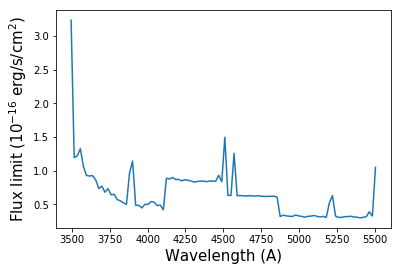

In [8]:
from numpy import linspace
wls = linspace(3495.0, 5505.0, 100)
flims = scube.get_f50(ra, dec, wls)
plt.plot(wls[flims < 999], flims[flims < 999]*1e16)
plt.xlabel("Wavelength (A)", fontsize=15.0)
plt.ylabel("Flux limit ($10^{-16}$ erg/s/cm$^2$)", fontsize=15.0)

To get the fraction of sources detected at a particular flux, rather than just the flux limit value one can use this method

In [9]:
# Flux (cgs) RA DEC (in degrees) Wavelength (Angstrom) 
scube.return_completeness(4.1e-17, ra, dec, 4245)

0.02836098131152931

This completeness is computed using a functional form, this function takes two parameters the flux limit and a slope which controls how quickly completeness falls off. The latter is fixed to our best guess in this version of the API (**this means it might not be all that accurate!**), in the future this will all be better tested. By definition the flux limit stored in the cubes corresponds to 50% completeness, i.e.

In [10]:
flux = scube.get_f50(ra, dec, 4245)
scube.return_completeness(flux, ra, dec, 4245)

0.5

To finish off, here is a plot of the completeness versus flux at some position. Note we use the flux limit computed above to define the range of the plot

Text(0,0.5,'Detected Fraction')

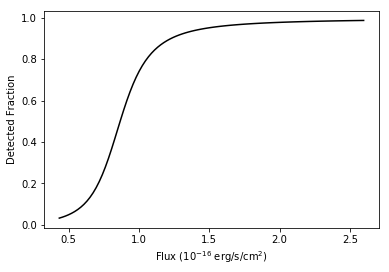

In [11]:
fluxes = linspace(0.5*flux, 3.0*flux, 100)
compl = scube.return_completeness(fluxes, ra, dec, 4245)
plt.plot(fluxes*1e16, compl, "k-")
plt.xlabel("Flux ($10^{-16}$ erg/s/cm$^2$)")
plt.ylabel("Detected Fraction")

## Looping over all the IFUs in an HDF5 file
If you want to loop over all the IFUs then an iterator is provided. It returns pairs of IFU slot and sensitivity cube. In this example we overplot flux limits for all of the IFUs in the shot

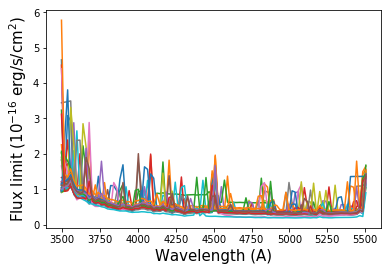

In [12]:
for ifu_name, scube in hdfcont.itercubes():
    
    # Compute the central RA, DEC from the cubes WCS
    shape = scube.f50vals.shape
    ra, dec, lambda_ = scube.wcs.all_pix2world(shape[2]/2., shape[1]/2., shape[0]/2., 0)
    
    # Get the flux limits at this RA/DEC and a range of wavelengths
    flims = scube.get_f50(ra, dec, wls)

    # Plot
    plt.plot(wls[flims < 999], flims[flims < 999]*1e16, label=ifu_name)

plt.xlabel("Wavelength (A)", fontsize=15.0)
plt.ylabel("Flux limit ($10^{-16}$ erg/s/cm$^2$)", fontsize=15.0)
plt.show()

    